# RNN Example 
This notebook demonstrates the capabilities of the RNN model in scalecast.  
Concepts covered:  
1. EDA on a big dataset  
2. SimpleRNN modeling  
3. LSTM modeling  
4. NNAR modeling  
5. Feature importance  

- Download data: https://www.kaggle.com/robervalt/sunspots
- Requirements for this notebook:  
  - `!pip install tqdm`  
  - `!pip install ipython`  
  - `!pip install ipywidgets`  
  - `!jupyter nbextension enable --py widgetsnbextension`  
  - if using Jupyter Lab: `!jupyter labextension install @jupyter-widgets/jupyterlab-manager`  
  
The utilized dataset measures average monthly sunspots since the 1700s, with over 3,000 datapoints. This dataset is a bit larger than what a typical dataset you would want to use scalecast for looks like, but it will definitely work for the purposes of demonstrating these advanced neural net models.  

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
df = pd.read_csv('Sunspots.csv',index_col=0,names=['Date','Target'],header=0)
f = Forecaster(y=df['Target'],current_dates=df['Date'])
f

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

## EDA

Text(0.5, 1.0, 'Original Sunspots Series')

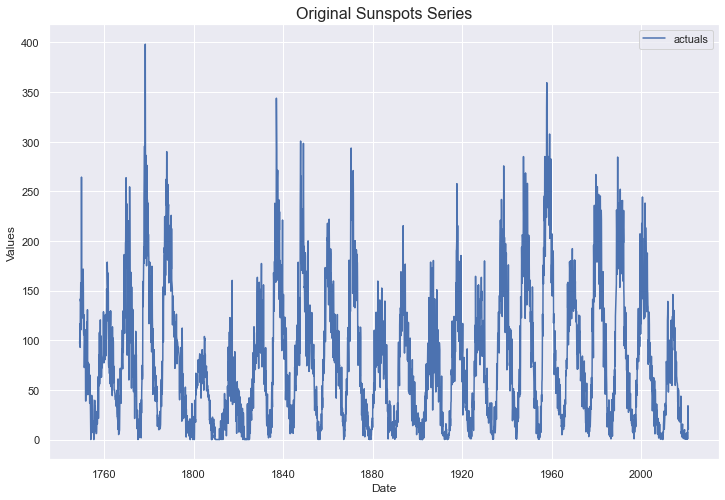

In [3]:
f.plot()
plt.title('Original Sunspots Series',size=16)

Let's see the ACF and PACF plots, allowing 240 lags to see this series' irregular 10-year cycle.

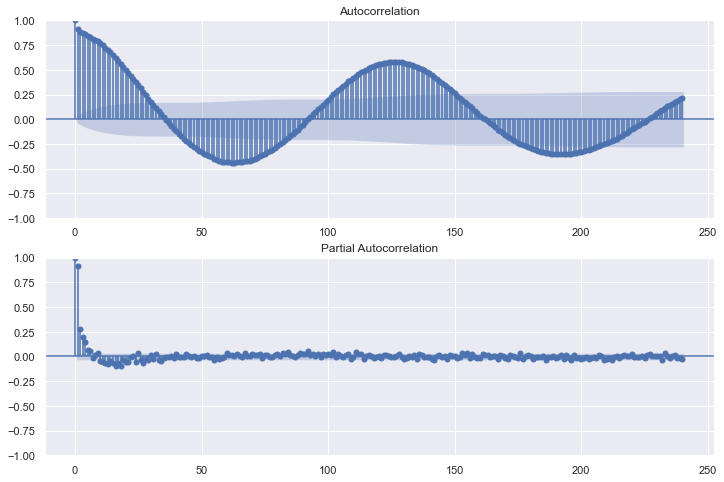

In [4]:
figs, axs = plt.subplots(2, 1)
f.plot_acf(ax=axs[0],lags=240)
f.plot_pacf(ax=axs[1],lags=240)
plt.show()

We will not worry about stationarity or seasonal decomposition, as you don't usually need to with these types of models.

## Prepare RNN Model
- Set test length (240 months / 2 years)
- Set forecast horizon (240 months / 2 years)
- Change bootstrap samples to 5,000 for more accurate confidence intervals
- Change CI level to 90% to make intervals less noticeable in graphs

In [5]:
f.set_test_length(240) # 20 years
f.generate_future_dates(240)
f.set_bootstrap_samples(5000)
f.set_cilevel(.9)

## Forecast RNN Model
- See Darts' GRU on the same series: https://unit8co.github.io/darts/examples/04-RNN-examples.html?highlight=sunspots

### SimpleRNN

#### Unlayered model
- 60 lags (half a cycle)
- 1 hidden layer with 20% dropout
- 25 epochs
- 20% validcation split
- 32 batch size
- Tanh activation
- Adam optimizer
- MAE loss function

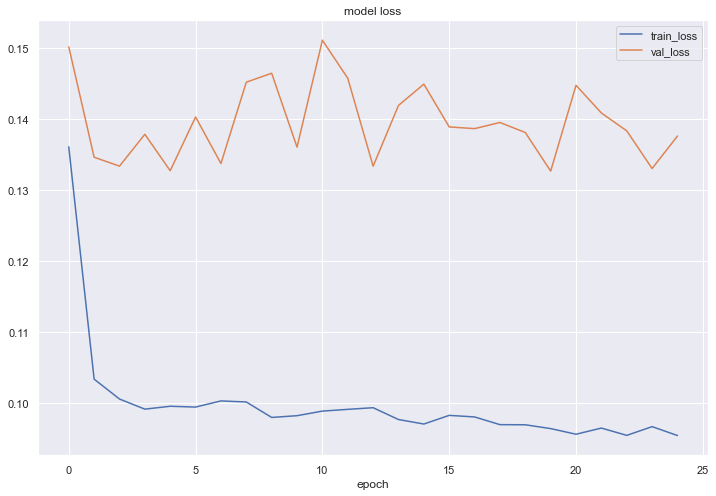

In [6]:
f.set_estimator('rnn')
f.manual_forecast(
    lags=60,
    hidden_layers_struct=[{'units':100,'dropout':0.2}],
    epochs=25,
    validation_split=0.2,
    plot_loss=True,
    call_me="rnn_1layer",
    verbose=0, # so it doesn't print each epoch and saves space in the notebook
)

#### Layered Model

- 120 lags -- one full seasonal cycle
- 10 hidden layers, 100 units each
- 100 epochs
- No dropout
- Everything else the same
- Takes a long time to run

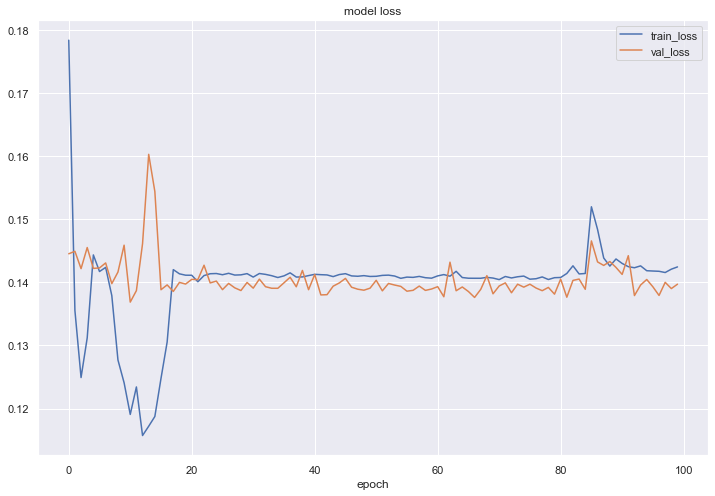

In [7]:
f.manual_forecast(
    lags=120,
    hidden_layers_struct=[{'units':100,'dropout':0}]*10,
    epochs=100,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='rnn_10layers',
    verbose=0
)

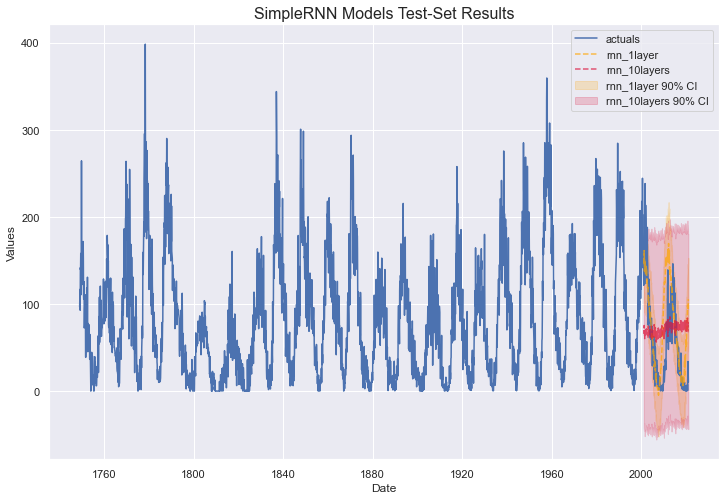

In [8]:
f.plot_test_set(ci=True,models=['rnn_1layer','rnn_10layers'],order_by='TestSetRMSE')
plt.title('SimpleRNN Models Test-Set Results',size=16)
plt.show()

Suprising, perhaps: the unlayered model performed significantly better than the complex model.

### LSTM

#### Unlayered Model
- 60 lags
- One hidden layer with 20% dropout
- 35 epochs
- LSTM cell

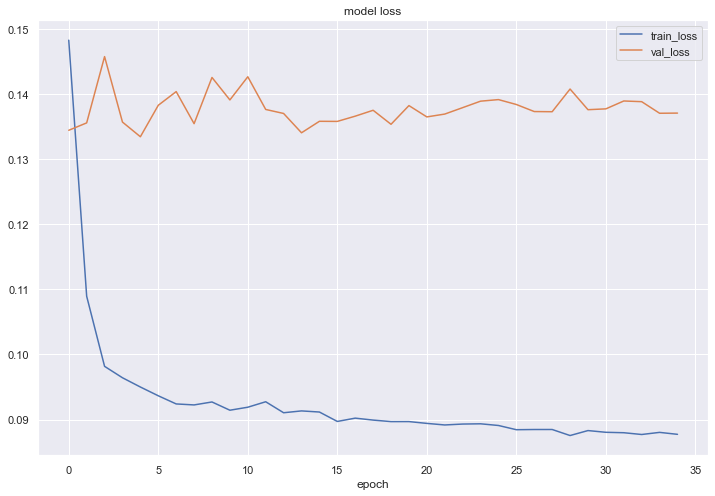

In [9]:
f.manual_forecast(
    lags=60,
    hidden_layers_type='LSTM',
    hidden_layers_struct=[{'units':100,'dropout':0.2}],
    epochs=35,
    validation_split=0.2,
    plot_loss=True,
    call_me="lstm_1layer",
    verbose=0, # so it doesn't print each epoch and saves space in the notebook
)

#### Layered Model

- 5 layers  
- No dropout
- 100 epochs
- Everything else the same
- Takes a really long time to run

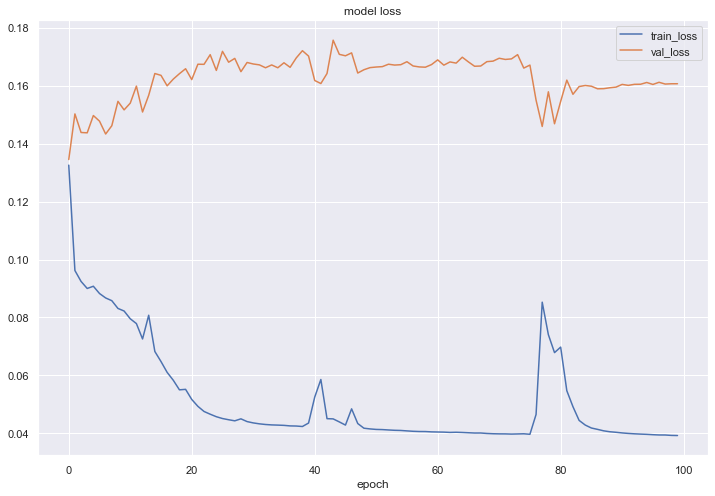

In [10]:
f.manual_forecast(
     lags=120,
     hidden_layers_type='LSTM',
     hidden_layers_struct=[{'units':100,'dropout':0}]*5,
     epochs=100,
     random_seed=42,
     plot_loss=True,
     validation_split=0.2,
     call_me='lstm_5layers',
     verbose=0
)

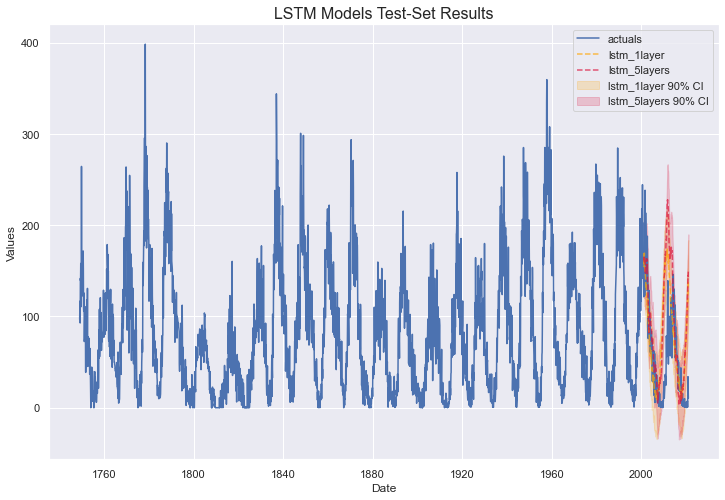

In [19]:
f.plot_test_set(models=['lstm_1layer','lstm_5layers'],ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results',size=16)
plt.show()

Both of these models seemed to fit fairly well.

## Prepare NNAR Model
- Let's try building a model you can read about here: https://otexts.com/fpp2/nnetar.html
- This is a time-series based dense neural network model, where the final predictions are the average of several models with randomly selected starting weights
- It is not a recurrent neural network and does not use the rnn estimator, but I thought it'd be fun to demonstrate here.
- It takes three input parameters: 
  - p (number of lags)
  - P (number of seasonal lags)
  - m (seasonal period)
- It also accepts exogenous variables. We add a time trend, monthly seasonality in wave functions, and a 120-period cycle
- Another parameter to consider is k: the size of the hidden layer. By default, this is the total number of inputs divided by 2, rounded up. We will keep the default
- The default number of models to average is 20 and we will keep that default as well
- See the model's documentation in R: https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/nnetar

In [12]:
p = 10 # non-seasonal lags
P = 6  # seasonal lags
m = 12 # seasonal period

f.add_ar_terms(p)
f.add_AR_terms((P,m))

# in addition to the process described in the linked book, we will try to improve results by adding a time trend
f.add_time_trend()
# we can also add monthly seasonality in a fournier transformation
f.add_seasonal_regressors('month',raw=False,sincos=True)
# lastly, we add an irregular 10-year cycle that is idionsycratic to this dataset
f.add_cycle(120)

In [13]:
f

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=240
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR12', 'AR24', 'AR36', 'AR48', 'AR60', 'AR72', 't', 'monthsin', 'monthcos', 'cycle120sin', 'cycle120cos']
    Differenced=0
    TestLength=240
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['rnn_1layer', 'rnn_10layers', 'lstm_1layer', 'lstm_5layers']
    CILevel=0.9
    BootstrapSamples=5000
    CurrentEstimator=rnn
)

## Forecast NNAR Model

In [14]:
# the default parameter used in the book is the total number of inputs divided by 2, rounded up
k = int(np.ceil(len(f.get_regressor_names())/2))
repeats = 20 # default repeats number used in book
f.set_estimator('mlp')
for r in tqdm(range(repeats)): # repeats
    f.manual_forecast(hidden_layer_sizes=(k,),
                      activation='relu',
                      random_state=r,
                      normalizer='scale',
                      call_me=f'mlp_{r}')
f.save_feature_importance()
# now we take the averages of all models to create the final NNAR
f.set_estimator('combo')
f.manual_forecast(how='simple',models=[f'mlp_{r}' for r in range(20)],call_me='nnar')

  0%|          | 0/20 [00:00<?, ?it/s]

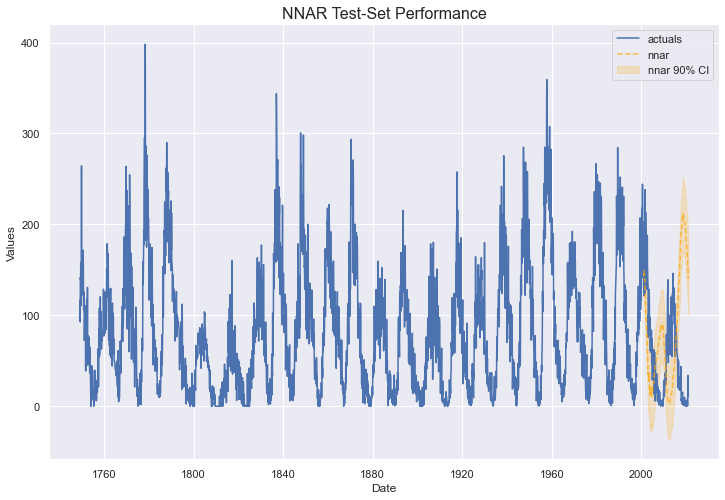

In [30]:
f.plot_test_set(ci=True,models='nnar')
plt.title('NNAR Test-Set Performance',size=16)
plt.show()

This doesn't look as good as any of our evaluated RNN models.

One thing we notice with all these test-set graphs is that the precise deviations from the trend are hard to see because the series is so large. Let's call the function again with all evaluated models ordered by test RMSE and zoomed in to the test-set section of the series only by setting `include_train=False`. 

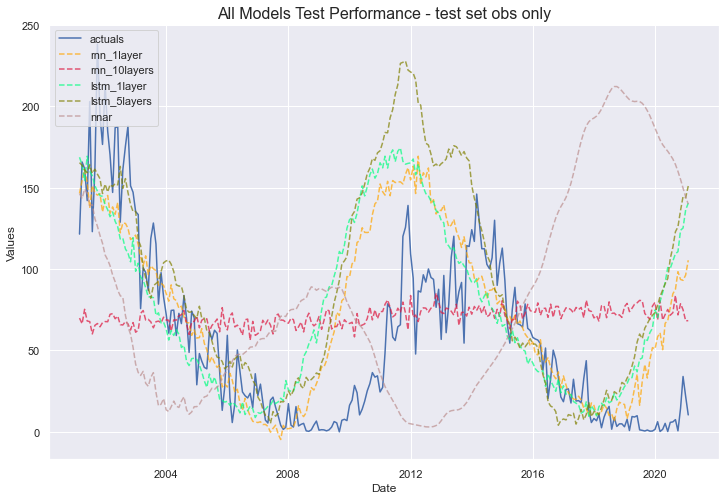

In [32]:
f.plot_test_set(
    models=['rnn_1layer','rnn_10layers','lstm_1layer','lstm_5layers','nnar'],
    order_by='TestSetRMSE',
    include_train=False,
)
plt.title('All Models Test Performance - test set obs only',size=16)
plt.show()

With this view, it is not clear that any model did as well as we might have thought from the other graphs.

## Compare All Models

### Forecast Plot
- best rnn model
- best lstm model
- nnar model

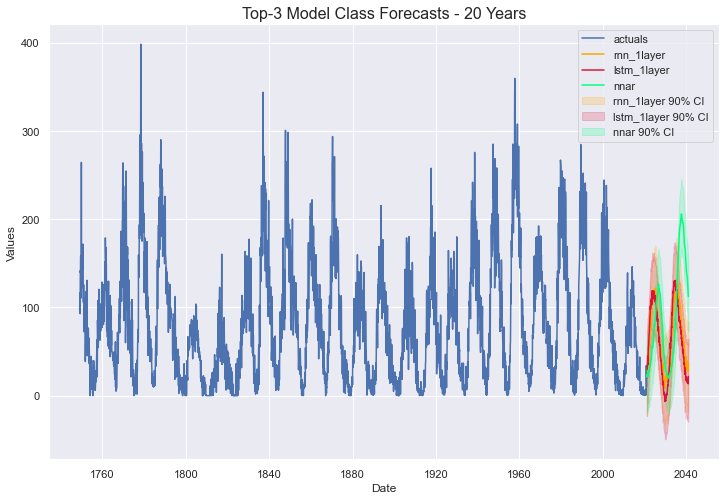

In [35]:
f.plot(models=['rnn_1layer','lstm_1layer','nnar'],order_by='TestSetRMSE',ci=True)
plt.title('Top-3 Model Class Forecasts - 20 Years',size=16)
plt.show()

### Export Model Summaries for all applied models

In [21]:
pd.set_option('display.float_format',  '{:.4f}'.format)
f.export('model_summaries',models=['rnn_1layer','rnn_10layers','lstm_1layer','lstm_5layers','nnar'])[
    [
        'ModelNickname',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,rnn_1layer,44.3569,0.2960,31.8569,0.7818,True
1,rnn_10layers,55.3890,-0.0977,67.8382,0.0183,False
2,lstm_1layer,55.6040,-0.1062,29.4114,0.8141,False
3,lstm_5layers,62.5693,-0.4007,25.0815,0.8658,False
4,nnar,99.3758,-2.5334,27.7120,0.8350,False


The RNN with 1 layer appears to be our most accurate model out of the 5 we ran. The NNAR model, in spite of being fun to set up, was the worst. Sometimes, simpler really is better, even for complex datasets. That's not to say the models found here are perfect. With more time spent, even better results could be extracted.

## Feature Importance
- One of the NNAR Input Models

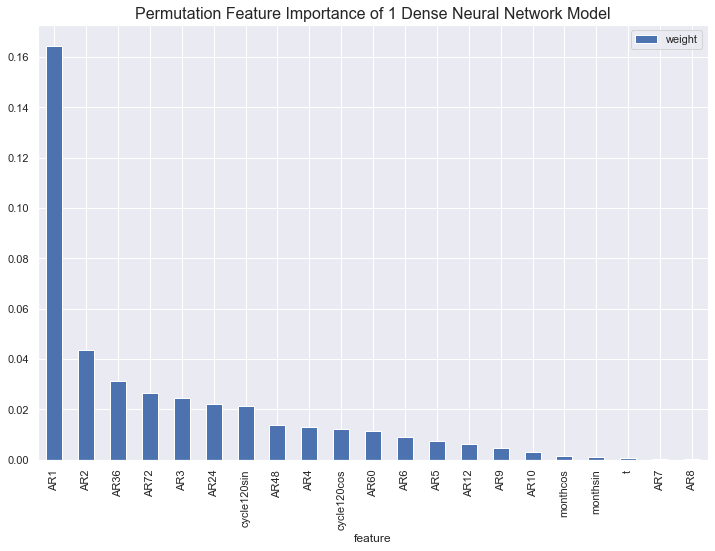

In [34]:
f.export_feature_importance('mlp_19').plot.bar(y='weight')
plt.title('Permutation Feature Importance of 1 Dense Neural Network Model',size=16)
plt.show()